In [1]:
import os 

import yfinance as yf 
import backtrader as bt 
import pandas as pd 
import matplotlib.pyplot as plt 
from datetime import datetime

In [2]:
if not os.path.exists('yfdata/'):
    os.mkdir('yfdata')
    
ticker = 'SPY'
data = yf.download(ticker, period='1y', interval='1d')
data_path = os.path.join('yfdata', ticker+'.csv')
data.to_csv(data_path)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Bollinger Band
# Buy --> price crosses lower band upward
# Sell --> price crosses upper band downward
# Buy as many shares as possible
# NO short selling

class BollingerBandStrategy(bt.Strategy):
    params = (('period',20), ('devfactor',2),)
    
    def __init__(self):
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open
        self.order = None
        self.price = None
        self.comm = None
        self.b_band = bt.ind.BollingerBands(self.datas[0], period=self.p.period, devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.top)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt} | {txt}")
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}")
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f"SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}")
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Failed")
        
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return 
        
        self.log(f"OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}")
        
    def next_open(self):
        # buy only if not yet have positions
        if not self.position:
            if self.buy_signal > 0:
                size = int(self.broker.getcash() / self.datas[0].open)
                self.log(f"BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}")
                self.buy(size=size)
        
        # sell only if already have positions
        else:
            if self.sell_signal < 0:
                self.log(f"SELL CREATED --- Size: {self.position.size}")
                self.sell(size=self.position.size)

In [4]:
data = bt.feeds.YahooFinanceCSVData(dataname=data_path)

In [5]:
cerebro = bt.Cerebro(stdstats=False, cheat_on_open=True)
cerebro.addstrategy(BollingerBandStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000)
cerebro.broker.setcommission(0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

In [6]:
print(f"Starting Porfolio Value: {cerebro.broker.getvalue():.2f}")
backtest_result = cerebro.run()
print(f"Final Porfolio Value: {cerebro.broker.getvalue():.2f}")

Starting Porfolio Value: 10000.00
2021-05-14 | BUY CREATED --- Size: 24, Cash: 10000.00, Open: 409.11, Close: 412.45
2021-05-14 | BUY EXECUTED --- Price: 409.11, Cost: 9818.64, Commission: 9.82
2021-06-30 | SELL CREATED --- Size: 24
2021-06-30 | SELL EXECUTED --- Price: 424.35, Cost: 9818.64, Commission: 10.18
2021-06-30 | OPERATION RESULT --- Gross: 365.76, Net: 345.76
2021-09-23 | BUY CREATED --- Size: 23, Cash: 10345.76, Open: 438.31, Close: 441.63
2021-09-23 | BUY EXECUTED --- Price: 438.31, Cost: 10081.13, Commission: 10.08
2021-10-22 | SELL CREATED --- Size: 23
2021-10-22 | SELL EXECUTED --- Price: 451.54, Cost: 10081.13, Commission: 10.39
2021-10-22 | OPERATION RESULT --- Gross: 304.29, Net: 283.82
2021-11-30 | BUY CREATED --- Size: 23, Cash: 10629.58, Open: 460.38, Close: 453.97
2021-11-30 | BUY EXECUTED --- Price: 460.38, Cost: 10588.74, Commission: 10.59
2021-12-29 | SELL CREATED --- Size: 23
2021-12-29 | SELL EXECUTED --- Price: 476.98, Cost: 10588.74, Commission: 10.97
2021

<IPython.core.display.Javascript object>


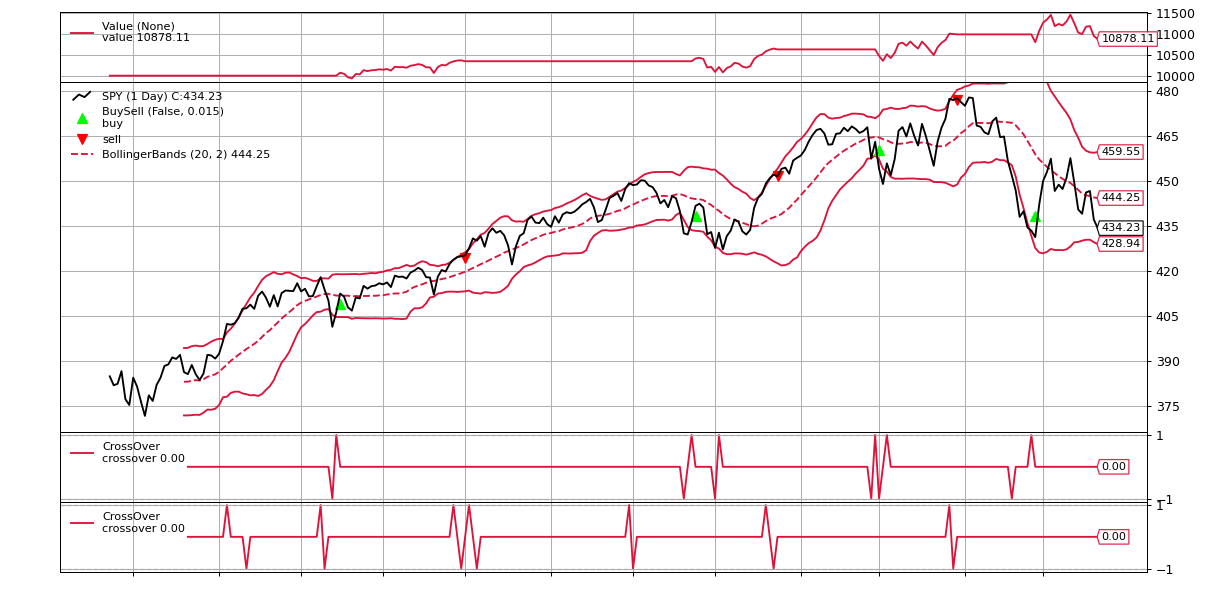

[[<Figure size 432x288 with 4 Axes>]]

In [7]:
cerebro.plot(iplot=True, volume=False)

In [8]:
backtest_result[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', 0.0841678457338821),
             ('ravg', 0.0003313694713932366),
             ('rnorm', 0.08709076682415026),
             ('rnorm100', 8.709076682415025)])

In [9]:
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), columns=['date', 'return']).set_index('date')

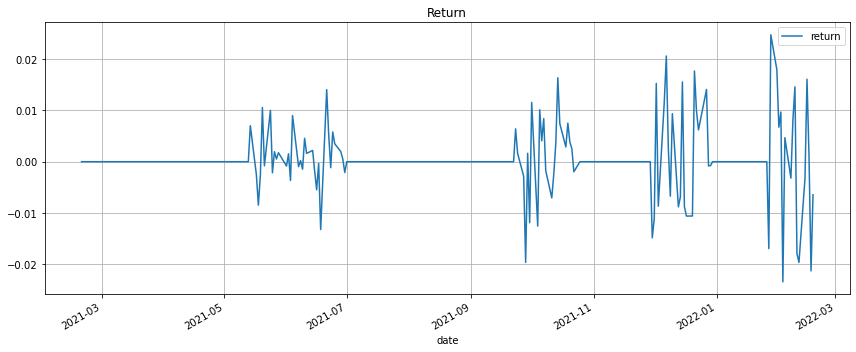

In [10]:
%matplotlib inline 
returns_df.plot(figsize=(12,5))
plt.title('Return')
plt.grid(True)
plt.tight_layout()
plt.show()

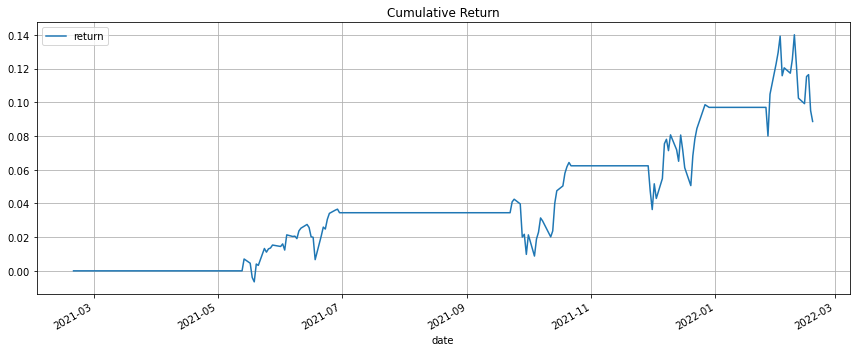

In [11]:
returns_df.cumsum().plot(figsize=(12,5))
plt.title('Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()